# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow those simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 4th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis). 


In [13]:
# import libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np  
import re
import os 
import pandas as pd
import seaborn as sns

In [14]:
# import network
import requests

url = "https://raw.githubusercontent.com/albapim/Social_Graphs_Assignments/refs/heads/main/rock_performers_graph.gexf"
r = requests.get(url)
with open("rock_performers_graph.gexf", "wb") as f:
    f.write(r.content)

# Load the rock music network from the GEXF file
rock_network = nx.read_gexf("rock_performers_graph.gexf")

In [15]:
# print some network statistics

# number of nodes
print("Number of nodes:", rock_network.number_of_nodes())
# number of edges
print("Number of edges:", rock_network.number_of_edges())

Number of nodes: 485
Number of edges: 13672



# Part 1: Analyze the network

The questions in this part are based on Lecture 5.

* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   - I would like you to include concepts like centrality and assortativity in your analysis.
   - Use a network backbone in your analysis.
   - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   - **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network. 



# Part 2: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.


In [21]:
def extract_genres_from_infobox(text):
    """
    Extracts the list of genres from the 'Infobox musical artist' wikitext.
    Maintains the order of genres as they appear in the infobox.

    Args:
        text (str): The complete wikitext of the Wikipedia page.

    Returns:
        list: A list of cleaned genre names (lowercase), in order of appearance.
    """
    
    # First, find the infobox in the text
    infobox_patterns = [
        r'\{\{[Ii]nfobox\s+musical\s+artist(.*?)\n\}\}',
        r'\{\{[Ii]nfobox\s+band(.*?)\n\}\}',
        r'\{\{[Ii]nfobox\s+person(.*?)\n\}\}',
        r'\{\{[Ii]nfobox\s+singer(.*?)\n\}\}'
    ]
    
    infobox_text = None
    for pattern in infobox_patterns:
        infobox_match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
        if infobox_match:
            infobox_text = infobox_match.group(1)
            break
    
    if not infobox_text:
        return []
    
    # Look for genre field
    genre_patterns = [
        r'\|\s*genres?\s*=\s*(.*?)(?=\n\s*\||\n\}\}|$)',  # genre or genres
        r'\|\s*style\s*=\s*(.*?)(?=\n\s*\||\n\}\}|$)',    # sometimes called style
    ]
    
    raw_genre_content = None
    for pattern in genre_patterns:
        genre_match = re.search(pattern, infobox_text, re.DOTALL | re.IGNORECASE)
        if genre_match:
            raw_genre_content = genre_match.group(1).strip()
            break
    
    if not raw_genre_content:
        return []
    
    genres = []  # Use list to maintain order
    
    # Handle flatlist specifically first (maintains order)
    if '{{flatlist|' in raw_genre_content.lower():
        flatlist_match = re.search(r'\{\{flatlist\|(.*?)\}\}', raw_genre_content, re.DOTALL | re.IGNORECASE)
        if flatlist_match:
            flatlist_content = flatlist_match.group(1)
            # Extract wiki links in order
            wiki_links = re.findall(r'\[\[([^|\]]+)(?:\|[^\]]+)?\]\]', flatlist_content)
            for link in wiki_links:
                clean_genre = link.strip().lower()
                if (not any(skip in clean_genre for skip in ['file:', 'category:', 'image:', 'cite', 'ref', 'allmusic', 'oxford', 'scotsman', 'riff']) and
                    (any(music_term in clean_genre for music_term in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'electronic', 'hip hop', 'rap', 'reggae', 'ska', 'funk', 'soul', 'indie', 'alternative', 'grunge', 'britpop', 'post-', 'new wave', 'disco', 'dance', 'house', 'techno', 'ambient', 'classical', 'opera', 'gospel', 'r&b', 'rhythm', 'power pop']) or
                     clean_genre in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'electronic', 'hip hop', 'rap', 'reggae', 'ska', 'funk', 'soul'])):
                    if clean_genre not in genres:  # Avoid duplicates while maintaining order
                        genres.append(clean_genre)
    
    # Method 1: Extract from wiki links [[Genre Name]] (if no flatlist found)
    if not genres:
        wiki_links = re.findall(r'\[\[([^|\]]+)(?:\|[^\]]+)?\]\]', raw_genre_content)
        for link in wiki_links:
            clean_genre = link.strip().lower()
            # Skip non-genre links and check if it's actually a music genre
            if (not any(skip in clean_genre for skip in ['file:', 'category:', 'image:', 'cite', 'ref', 'allmusic', 'oxford', 'scotsman', 'riff']) and
                (any(music_term in clean_genre for music_term in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'electronic', 'hip hop', 'rap', 'reggae', 'ska', 'funk', 'soul', 'indie', 'alternative', 'grunge', 'britpop', 'post-', 'new wave', 'disco', 'dance', 'house', 'techno', 'ambient', 'classical', 'opera', 'gospel', 'r&b', 'rhythm', 'power pop']) or
                 clean_genre in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'electronic', 'hip hop', 'rap', 'reggae', 'ska', 'funk', 'soul'])):
                if clean_genre not in genres:  # Avoid duplicates while maintaining order
                    genres.append(clean_genre)
    
    # Method 2: If no wiki links found, try other formats
    if not genres:
        # Remove references and citations first
        clean_content = re.sub(r'<ref[^>]*>.*?</ref>', '', raw_genre_content, flags=re.DOTALL)
        clean_content = re.sub(r'<[^>]+>', '', clean_content)
        clean_content = re.sub(r'\{\{[^}]+\}\}', '', clean_content)
        clean_content = re.sub(r'\[\[[^]]+\]\]', '', clean_content)
        
        # Split by common separators
        potential_genres = re.split(r'[,;•\n\*]+', clean_content)
        for genre in potential_genres:
            clean_genre = genre.strip().lower()
            if (clean_genre and len(clean_genre) > 2 and 
                any(music_term in clean_genre for music_term in ['rock', 'pop', 'jazz', 'blues', 'folk', 'country', 'punk', 'metal', 'new wave', 'grunge', 'power pop'])):
                if clean_genre not in genres:  # Avoid duplicates while maintaining order
                    genres.append(clean_genre)

    # Normalize common variations while maintaining order
    normalized_genres = []
    for genre in genres:
        # Common normalizations
        genre = genre.replace("rock'n'roll", "rock and roll")
        genre = genre.replace("rock & roll", "rock and roll")
        genre = genre.replace("r&b", "rhythm and blues")
        genre = genre.replace("rnb", "rhythm and blues")
        genre = genre.replace("hip-hop", "hip hop")
        genre = genre.replace("electro", "electronic")
        genre = genre.replace("alt rock", "alternative rock")
        genre = genre.replace("rhythm & blues", "rhythm and blues")
        genre = genre.replace("new wave music", "new wave")
        genre = genre.replace("rock music", "rock")
        genre = genre.replace(" music", "")  # Remove " music" suffix
        genre = genre.replace("british rock and roll", "rock and roll")
        genre = re.sub(r'\s+', ' ', genre).strip()  # Clean whitespace
        
        if genre and len(genre) > 1 and genre not in normalized_genres:
            normalized_genres.append(genre)
    
    return normalized_genres  # Return list maintaining order instead of list(set())

In [23]:
def extract_all_genres():
    """Extract genres for all artists in your network"""
    artist_genres = {}
    no_genres_count = 0
    
    folder = "artist_pages"
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            # Get artist name from filename
            artist_name = filename.replace(".txt", "").replace("_", " ")
            
            # Read the file
            filepath = os.path.join(folder, filename)
            with open(filepath, "r", encoding="utf-8") as f:
                text = f.read()
            
            # Extract genres
            genres = extract_genres_from_infobox(text)
            
            if genres:
                artist_genres[artist_name] = genres
                #print(f"{artist_name}: {genres}")
            else:
                no_genres_count += 1
                #print(f"{artist_name}: No genres found")
    
    print(f"\nSummary:")
    print(f"Artists with genres: {len(artist_genres)}")
    print(f"Artists without genres: {no_genres_count}")
    
    return artist_genres

# Run it
all_genres = extract_all_genres()




Summary:
Artists with genres: 420
Artists without genres: 63


{'groove metal', 'country rock', 'alternative metal', 'progressive rock', 'funk', 'gospel', 'indie rock', 'synth-pop', 'christian rock', 'post-britpop', 'funk rock', 'glam punk', 'arena rock', 'post-punk', 'heavy metal', 'electronicnic rock', 'rock', 'electronicnica', 'pub rock (united kingdom)', 'chamber pop', 'art rock', 'folk-rock', 'latin rock', 'baroque pop', 'frat rock', 'progressive pop', 'sunshine pop', 'street punk', 'roots rock', 'sophisti-pop', 'instrumental rock', 'surf rock', 'noise pop', 'alternative hip hop', 'folk-pop', 'post punk revival', 'yacht rock', 'math rock', 'indian classical', 'dance-rock', 'horror punk', 'jazz&nbsp;rock', 'raga rock', 'avant-funk', 'speed metal', 'folk pop', 'gothic rock', 'alternative country', 'symphonic rock', 'punk blues', 'stoner rock', 'rock and roll', 'space rock', 'nu metal', 'classical', 'art punk', 'ska punk', 'swamp rock', 'progressive metal', 'pop punk', 'rap-metal', 'pop-punk', 'heartland rock', 'disco', 'hip hop', 'reggae', 'blu

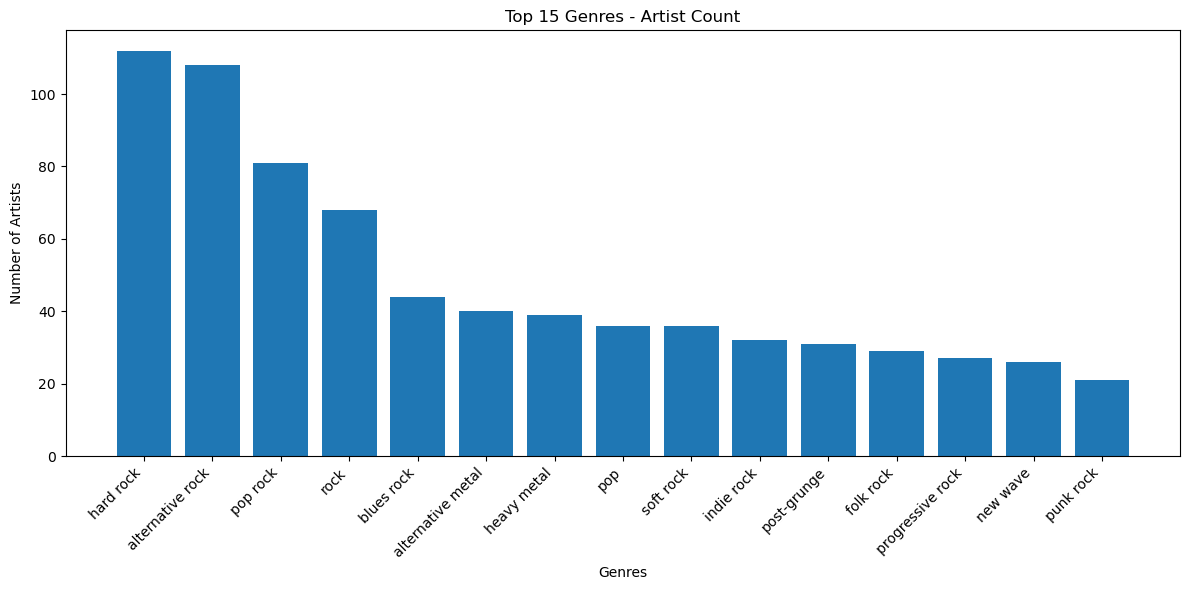

In [49]:
# Calculate statistics
if all_genres:
    # Number of nodes with genres
    nodes_with_genres = len(all_genres)
    
    # Average number of genres per node
    total_genres = sum(len(genres) for genres in all_genres.values())
    avg_genres = total_genres / nodes_with_genres
    
    # Total distinct genres
    all_unique_genres = set()
    for genres in all_genres.values():
        all_unique_genres.update(genres)
    distinct_genres = len(all_unique_genres)
    print(all_unique_genres)
    
    # Count frequency of each genre
    genre_counts = {}
    for genres in all_genres.values():
        for genre in genres:
            genre_counts[genre] = genre_counts.get(genre, 0) + 1
    
    # Top 15 genres
    top_15_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:15]
    
    print(f"\nStatistics:")
    print(f"Number of nodes with genres: {nodes_with_genres}")
    print(f"Average genres per node: {avg_genres:.2f}")
    print(f"Total distinct genres: {distinct_genres}")
    print(f"\nTop 15 genres:")
    for genre, count in top_15_genres:
        print(f"  {genre}: {count}")
    
    # Create histogram
    import matplotlib.pyplot as plt
    
    genres, counts = zip(*top_15_genres)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(genres)), counts)
    plt.xlabel('Genres')
    plt.ylabel('Number of Artists')
    plt.title('Top 15 Genres - Artist Count')
    plt.xticks(range(len(genres)), genres, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [56]:
# make the network undirected
rock_network = rock_network.to_undirected()

In [57]:
def convert_name_to_node_format(artist_name):
    """Convert artist name to match network node format"""
    # Start with the basic space to underscore conversion
    node_name = artist_name.replace(" ", "_")
    
    # Handle special characters that might be encoded differently
    # Check if the simple conversion exists first
    if node_name in rock_network.nodes():
        return node_name
    
    # Try different variations for common special characters
    variations = [
        node_name,
        node_name.replace("'", "%27"),  # URL encoding for apostrophe
        node_name.replace("&", "%26"),  # URL encoding for ampersand
        node_name.replace(",", "%2C"),  # URL encoding for comma
        node_name.replace("'", ""),     # Remove apostrophe completely
        node_name.replace("&", "and"),  # Replace & with "and"
        node_name.replace(",", ""),     # Remove comma completely
    ]
    
    # Check which variation exists in the network
    for variation in variations:
        if variation in rock_network.nodes():
            return variation
    
    return node_name  # Return original if no match found

# Fix the key mismatch with better name conversion
all_genres_fixed = {}
for artist, genres in all_genres.items():
    node_name = convert_name_to_node_format(artist)
    all_genres_fixed[node_name] = genres[0] if genres else None

# Now set the node attributes with the corrected keys
nx.set_node_attributes(rock_network, all_genres_fixed, 'genre')

# Remove nodes that don't have genres
nodes_to_remove = [node for node in rock_network.nodes() if 'genre' not in rock_network.nodes[node] or rock_network.nodes[node]['genre'] is None]
rock_network.remove_nodes_from(nodes_to_remove)

print(f"Final network size: {rock_network.number_of_nodes()}")
print(f"Nodes removed: {len(nodes_to_remove)}")

# Verify it worked
print("\nSample nodes with their genre attribute:")
for node in list(rock_network.nodes())[:5]:
    genre = rock_network.nodes[node].get('genre', 'No genre')
    print(f"{node}: {genre}")

Final network size: 417
Nodes removed: 0

Sample nodes with their genre attribute:
Slayer: thrash metal
Ted_Nugent: hard rock
Great_White: hard rock
Days_of_the_New: post-grunge
The_Dave_Clark_Five: rock and roll


In [58]:
# Create 15 genre groups from the detailed genre list
genre_groups = {
    'Hard Rock': ['hard rock', 'arena rock', 'shock rock', 'boogie rock', 'acid rock'],
    
    'Alternative Rock': ['alternative rock', 'post-grunge', 'indie rock', 'art rock', 'experimental rock', 'garage rock', 'garage rock revival', 'noise rock'],
    
    'Pop Rock': ['pop rock', 'pop', 'soft rock', 'power pop', 'indie pop', 'jangle pop', 'art pop', 'progressive pop', 'baroque pop', 'chamber pop'],
    
    'Classic Rock': ['rock', 'rock and roll', 'roots rock', 'heartland rock', 'album-oriented rock', 'instrumental rock', 'acoustic rock'],
    
    'Blues & Blues Rock': ['blues rock', 'blues', 'blue-eyed soul', 'punk blues', 'british blues', 'rhythm and blues', 'contemporary rhythm and blues', 'new orleans rhythm and blues', 'british rhythm and blues'],
    
    'Heavy Metal': ['alternative metal', 'heavy metal', 'nu metal', 'thrash metal', 'groove metal', 'progressive metal', 'funk metal', 'industrial metal', 'metalcore', 'death metal', 'melodic metalcore', 'gothic metal', 'symphonic metal', 'post-metal', 'speed metal', 'stoner rock'],
    
    'Progressive & Art': ['progressive rock', 'jazz rock', 'jazz fusion', 'symphonic rock', 'math rock', 'space rock', 'raga rock'],
    
    'Punk & Post-Punk': ['punk rock', 'post-punk', 'post-punk revival', 'pop-punk', 'ska punk', 'skate punk', 'proto-punk', 'celtic punk', 'folk punk', 'glam punk', 'art punk', 'street punk', 'horror punk', 'garage punk (fusion genre)', 'dance-punk'],
    
    'New Wave & Synth': ['new wave', 'synth-pop', 'electronicpop', 'electronicnic', 'electronicnic rock', 'electronicnic-rock', 'electronicnica', 'electronicnic dance', 'dance-rock', 'dance-pop', 'alternative dance'],
    
    'Folk & Country': ['folk rock', 'country rock', 'country', 'folk', 'indie folk', 'contemporary folk', 'folk pop', 'folk-pop', 'folk-rock', 'folk (music)', 'alternative country', 'progressive country', 'psychedelic folk'],
    
    'Glam & Psychedelic': ['glam metal', 'glam rock', 'psychedelic rock', 'psychedelic funk', 'psychedelic soul', 'psychedelic pop', 'sunshine pop', 'dream pop'],
    
    'Grunge & Alternative Metal': ['grunge', 'post-hardcore', 'industrial rock', 'rap rock', 'rap metal', 'rap-metal', 'nu&nbsp;metal', 'alternative hip hop'],
    
    'Soul & Funk': ['soul', 'funk', 'funk rock', 'funk metal', 'disco', 'reggae', 'reggae rock', 'avant-funk', 'neo soul', 'progressive soul'],
    
    'Pop & Electronic': ['britpop', 'sophisti-pop', 'alternative pop', 'traditional pop', 'yacht rock', 'emo pop', 'pop rap', 'pop punk', 'post-britpop', 'geek rock'],
    
    'Regional & Specialty': ['southern rock', 'rockabilly', 'christian rock', 'comedy rock', 'gothic rock', 'chicano rock', 'latin rock', 'pub rock (united kingdom)', 'pub rock (australia)', 'swamp rock', 'jam rock', 'frat rock', 'surf rock', 'classical', 'jazz', 'gospel', 'hip hop', 'indian classical', 'noise pop']
}

# Function to map individual genres to groups
def map_genre_to_group(genre):
    for group_name, genres_in_group in genre_groups.items():
        if genre in genres_in_group:
            return group_name
    return 'Other'  # fallback for any unmapped genres

# Apply grouping to your network
for node in rock_network.nodes():
    if 'genre' in rock_network.nodes[node]:
        original_genre = rock_network.nodes[node]['genre']
        grouped_genre = map_genre_to_group(original_genre)
        rock_network.nodes[node]['genre_group'] = grouped_genre

# Count the distribution of genre groups
genre_group_counts = {}
for node in rock_network.nodes():
    if 'genre_group' in rock_network.nodes[node]:
        group = rock_network.nodes[node]['genre_group']
        genre_group_counts[group] = genre_group_counts.get(group, 0) + 1

# Display the results
print("Genre Group Distribution:")
for group, count in sorted(genre_group_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{group}: {count}")

Genre Group Distribution:
Alternative Rock: 85
Classic Rock: 78
Hard Rock: 51
Heavy Metal: 46
Pop Rock: 35
Punk & Post-Punk: 22
Progressive & Art: 18
Blues & Blues Rock: 15
Folk & Country: 15
Glam & Psychedelic: 13
Regional & Specialty: 13
New Wave & Synth: 12
Grunge & Alternative Metal: 6
Soul & Funk: 5
Pop & Electronic: 3


/var/folders/tf/4m3mvmrd1ddgcyk882fq_c140000gn/T/ipykernel_96474/2259515524.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.tab20(unique_colors[i]), s=50, label=genre)


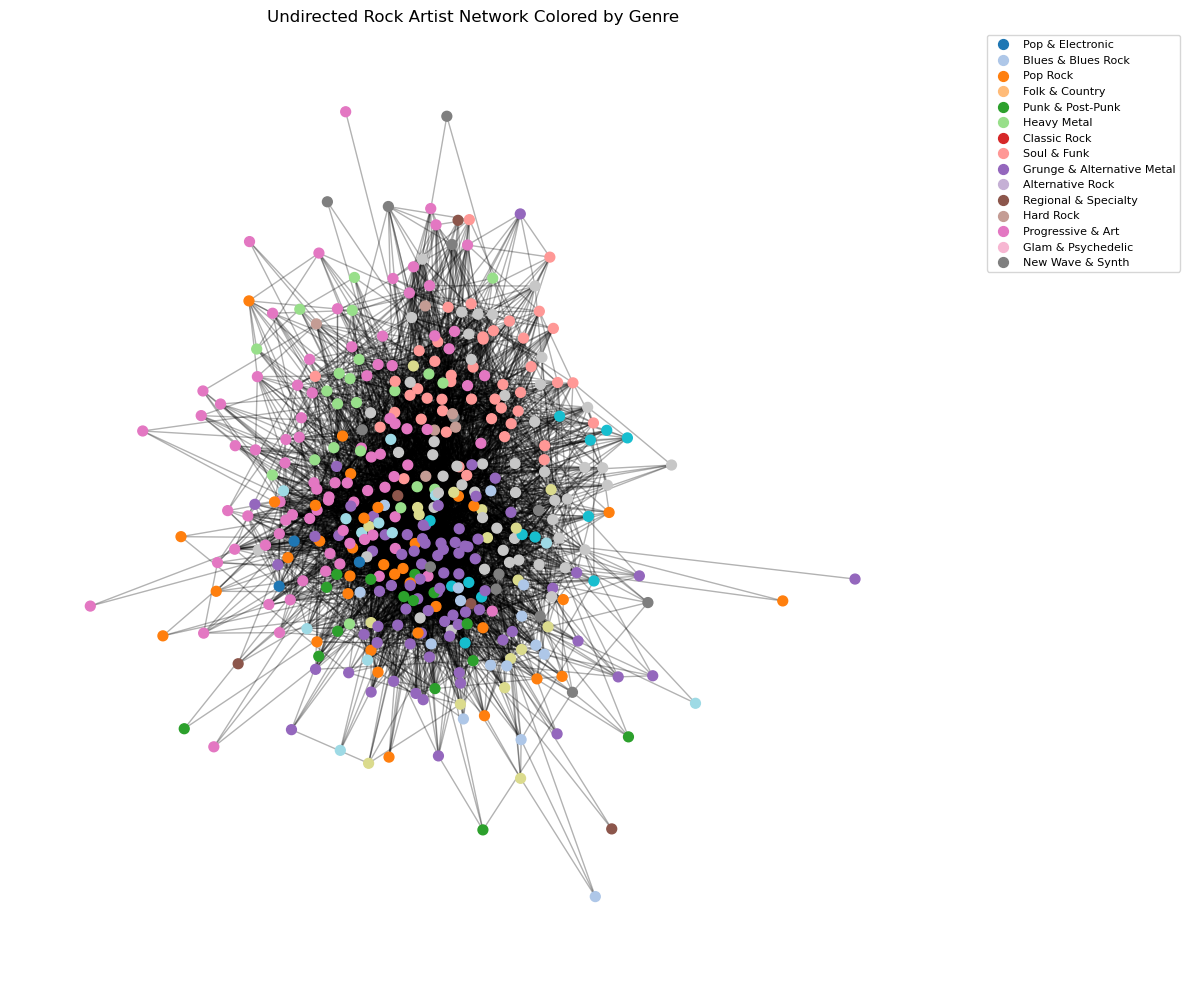

Network has 15 different genres
Top 10 genres: [('Alternative Rock', 85), ('Classic Rock', 78), ('Hard Rock', 51), ('Heavy Metal', 46), ('Pop Rock', 35), ('Punk & Post-Punk', 22), ('Progressive & Art', 18), ('Blues & Blues Rock', 15), ('Folk & Country', 15), ('Regional & Specialty', 13)]


In [59]:
import matplotlib.pyplot as plt
import numpy as np

G_main = rock_network

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_main, seed=42)  # For consistent layout

# Get all unique genres and map them to numbers
unique_genres = list(set(G_main.nodes[node]['genre_group'] for node in G_main.nodes()))
genre_to_number = {genre: i for i, genre in enumerate(unique_genres)}

# Convert genre names to numbers for coloring
node_colors = [genre_to_number[G_main.nodes[node]['genre_group']] for node in G_main.nodes()]

# Create the plot
nx.draw_networkx_nodes(G_main, pos, node_size=50, 
                      node_color=node_colors, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G_main, pos, alpha=0.3)
plt.title("Undirected Rock Artist Network Colored by Genre")

# Create a legend
unique_colors = [genre_to_number[genre] for genre in unique_genres]
for i, genre in enumerate(unique_genres):  # Show only first 10 genres to avoid clutter
    plt.scatter([], [], c=plt.cm.tab20(unique_colors[i]), s=50, label=genre)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Network has {len(unique_genres)} different genres")
print(f"Top 10 genres: {sorted([(genre, list(G_main.nodes[node]['genre_group'] for node in G_main.nodes()).count(genre)) for genre in unique_genres], key=lambda x: x[1], reverse=True)[:10]}")

In [62]:
def calculate_community_modularity(G, community_nodes):
    """
    Calculate modularity for a single community using the formula:
    Mc = Lc/L - (kc/2L)^2
    
    Args:
        G: NetworkX graph
        community_nodes: list of nodes in the community
        
    Returns:
        float: modularity value for the community
    """
    # Total number of edges in the graph
    L = G.number_of_edges()
    
    if L == 0:
        return 0
    
    # Create subgraph for the community
    community_subgraph = G.subgraph(community_nodes)
    
    # Lc: number of edges within the community
    Lc = community_subgraph.number_of_edges()
    
    # kc: sum of degrees of all nodes in the community
    kc = sum(G.degree(node) for node in community_nodes)
    
    # Calculate modularity for this community
    Mc = Lc / L - (kc / (2 * L)) ** 2
    
    return Mc

def calculate_all_communities_modularity(G):
    """
    Calculate modularity for each genre-based community in the graph
    
    Args:
        G: NetworkX graph with 'genre' node attribute
        
    Returns:
        dict: mapping of genre to modularity value
    """
    # Group nodes by genre
    genre_communities = {}
    for node in G.nodes():
        genre = G.nodes[node]['genre_group']
        if genre not in genre_communities:
            genre_communities[genre] = []
        genre_communities[genre].append(node)
    
    # Calculate modularity for each community
    community_modularities = {}
    for genre, nodes in genre_communities.items():
        modularity = calculate_community_modularity(G, nodes)
        community_modularities[genre] = modularity
        print(f"Genre '{genre}': {len(nodes)} nodes, modularity = {modularity:.4f}")
    
    return community_modularities

# Calculate modularity for all genre-based communities
print("Calculating modularity for each genre-based community:")
modularities = calculate_all_communities_modularity(G_main)

# Total modularity (sum of all community modularities)
total_modularity = sum(modularities.values())
print(f"\nTotal network modularity: {total_modularity:.4f}")

# Sort by modularity to see best communities
sorted_modularities = sorted(modularities.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 5 communities by modularity:")
for genre, mod in sorted_modularities[:5]:
    print(f"  {genre}: {mod:.4f}")


Calculating modularity for each genre-based community:
Genre 'Heavy Metal': 46 nodes, modularity = 0.0390
Genre 'Hard Rock': 51 nodes, modularity = 0.0142
Genre 'Alternative Rock': 85 nodes, modularity = 0.0249
Genre 'Classic Rock': 78 nodes, modularity = 0.0258
Genre 'Punk & Post-Punk': 22 nodes, modularity = 0.0073
Genre 'Glam & Psychedelic': 13 nodes, modularity = 0.0021
Genre 'Blues & Blues Rock': 15 nodes, modularity = 0.0015
Genre 'Regional & Specialty': 13 nodes, modularity = 0.0009
Genre 'Progressive & Art': 18 nodes, modularity = 0.0030
Genre 'Grunge & Alternative Metal': 6 nodes, modularity = -0.0000
Genre 'Pop Rock': 35 nodes, modularity = 0.0044
Genre 'New Wave & Synth': 12 nodes, modularity = 0.0012
Genre 'Folk & Country': 15 nodes, modularity = 0.0017
Genre 'Pop & Electronic': 3 nodes, modularity = 0.0001
Genre 'Soul & Funk': 5 nodes, modularity = 0.0002

Total network modularity: 0.1263

Top 5 communities by modularity:
  Heavy Metal: 0.0390
  Classic Rock: 0.0258
  Alte

In [63]:
# modularity
modularity = nx.community.modularity(G_main, nx.community.louvain_communities(G_main))
print(f"Louvain method modularity: {modularity:.4f}")

Louvain method modularity: 0.2889


Louvain method modularity: 0.2945
Number of communities found: 4
Community-Genre Analysis:
--------------------------------------------------
Community 0 (132 nodes):
  Top genres: [('Heavy Metal', 45), ('Hard Rock', 38), ('Alternative Rock', 23)]
  Example artists: ['Disturbed_(band)', 'Damn_Yankees_(band)', 'Iron_Maiden']

Community 1 (31 nodes):
  Top genres: [('Hard Rock', 6), ('Pop Rock', 6), ('Alternative Rock', 6)]
  Example artists: ['Bon_Jovi', 'Foster_the_People', 'Jim_Croce']

Community 2 (130 nodes):
  Top genres: [('Alternative Rock', 52), ('Classic Rock', 20), ('Punk & Post-Punk', 19)]
  Example artists: ['The_White_Stripes', 'The_Lumineers', 'James_Blunt']

Community 3 (124 nodes):
  Top genres: [('Classic Rock', 50), ('Pop Rock', 14), ('Blues & Blues Rock', 13)]
  Example artists: ['Linda_Ronstadt', 'The_Beach_Boys', 'The_Who']

Community sizes: [(0, 132), (2, 130), (3, 124), (1, 31)]


/var/folders/tf/4m3mvmrd1ddgcyk882fq_c140000gn/T/ipykernel_96474/1283786743.py:93: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], s=100, label=f'Community {comm_id} ({size} nodes)')


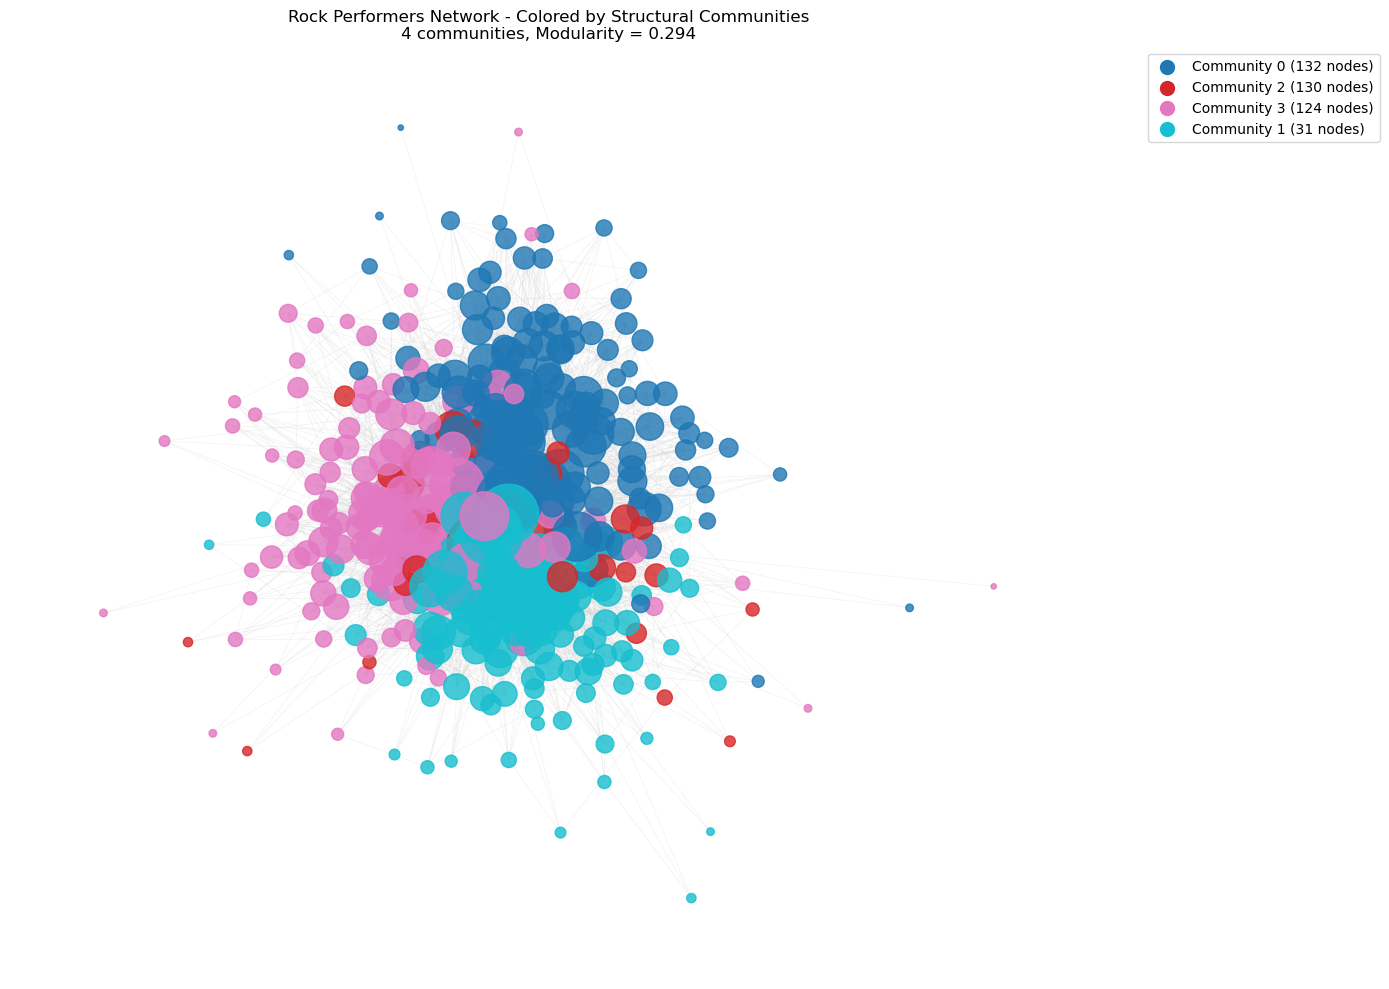


Community Statistics:
Total communities: 4
Largest community size: 132
Smallest community size: 31
Average community size: 104.25


In [ ]:
# Find structural communities using Louvain algorithm
louvain_communities = nx.community.louvain_communities(G_main)
modularity = nx.community.modularity(G_main, louvain_communities)
print(f"Louvain method modularity: {modularity:.4f}")
print(f"Number of communities found: {len(louvain_communities)}")


# Analyze genre composition within each community
print("Community-Genre Analysis:")
print("-" * 50)

for i, community in enumerate(louvain_communities):
    if len(community) >= 5:  # Only show communities with 5+ nodes
        print(f"Community {i} ({len(community)} nodes):")
        
        # Count genres in this community
        genre_counts = {}
        for node in community:
            if node in G_main.nodes():
                genre = G_main.nodes[node].get('genre_group')
                genre_counts[genre] = genre_counts.get(genre, 0) + 1
        
        # Sort by frequency
        sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
        
        print(f"  Top genres: {sorted_genres[:3]}")
        print(f"  Example artists: {list(community)[:3]}")
        print()

# Create a mapping from node to community ID
node_to_community = {}
for i, community in enumerate(louvain_communities):
    for node in community:
        node_to_community[node] = i

# Get community sizes and sort by size
community_sizes = [(i, len(community)) for i, community in enumerate(louvain_communities)]
community_sizes.sort(key=lambda x: x[1], reverse=True)
print("Community sizes:", [(i, size) for i, size in community_sizes[:10]])

# Create layout
pos = nx.spring_layout(G_main, seed=42)  # ForceAtlas2 might not be available, using spring

# Get node degrees and community assignments
degrees = [G_main.degree(node) for node in G_main.nodes()]
node_communities = [node_to_community[node] for node in G_main.nodes()]

# Create visualization
plt.figure(figsize=(14, 10))

# If there are many small communities, color only the largest ones
n_largest_communities = min(10, len(louvain_communities))  # Color top 10 communities
largest_community_ids = [comm_id for comm_id, size in community_sizes[:n_largest_communities]]

# Create color mapping
node_colors = []
for node in G_main.nodes():
    comm_id = node_to_community[node]
    if comm_id in largest_community_ids:
        node_colors.append(comm_id)
    else:
        node_colors.append(-1)  # Use -1 for small communities (will be gray)

# Draw edges first
nx.draw_networkx_edges(G_main, pos, edge_color='lightgray', alpha=0.3, width=0.5)

# Draw nodes with colors based on community
# Use a colormap that handles the -1 values for small communities
import matplotlib.cm as cm
import numpy as np

# Create custom colormap
n_colors = len(largest_community_ids)
colors = cm.tab10(np.linspace(0, 1, n_colors))  # Get distinct colors
cmap = cm.colors.ListedColormap(['lightgray'] + list(colors))

nodes = nx.draw_networkx_nodes(G_main, pos, 
                              node_size=[d*15 for d in degrees],  # size by degree
                              node_color=node_colors,             # color by community
                              cmap=cmap,                          # custom colormap
                              vmin=-1,                            # include gray for small communities
                              vmax=max(largest_community_ids),
                              alpha=0.8)

plt.title(f'Rock Performers Network - Colored by Structural Communities\n{len(louvain_communities)} communities, Modularity = {modularity:.3f}')

# Create legend for largest communities
for i, (comm_id, size) in enumerate(community_sizes[:n_largest_communities]):
    plt.scatter([], [], c=colors[i], s=100, label=f'Community {comm_id} ({size} nodes)')

# Add legend for small communities
if len(louvain_communities) > n_largest_communities:
    small_communities_count = len(louvain_communities) - n_largest_communities
    total_small_nodes = sum(size for comm_id, size in community_sizes[n_largest_communities:])
    plt.scatter([], [], c='lightgray', s=100, 
               label=f'{small_communities_count} small communities ({total_small_nodes} nodes)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print some statistics about the communities
print(f"\nCommunity Statistics:")
print(f"Total communities: {len(louvain_communities)}")
print(f"Largest community size: {community_sizes[0][1]}")
print(f"Smallest community size: {community_sizes[-1][1]}")
print(f"Average community size: {np.mean([size for _, size in community_sizes]):.2f}")

Top 7 genres:
  1. Alternative Rock: 85 nodes
  2. Classic Rock: 78 nodes
  3. Hard Rock: 51 nodes
  4. Heavy Metal: 46 nodes
  5. Pop Rock: 35 nodes
  6. Punk & Post-Punk: 22 nodes
  7. Progressive & Art: 18 nodes

Top 7 communities:
  1. Community 0: 132 nodes
  2. Community 2: 130 nodes
  3. Community 3: 124 nodes
  4. Community 1: 31 nodes

Confusion Matrix D (7 genres × 4 communities):
Rows = Genres, Columns = Communities
Matrix shape: (7, 4)

Confusion Matrix:
                       C0: Comm0  C1: Comm2  C2: Comm3  C3: Comm1
G0: Alternative Rock          23         52          4          6
G1: Classic Rock               4         20         50          4
G2: Hard Rock                 38          3          4          6
G3: Heavy Metal               45          1          0          0
G4: Pop Rock                   2         13         14          6
G5: Punk & Post-Punk           1         19          2          0
G6: Progressive & Art          4          2          9          3


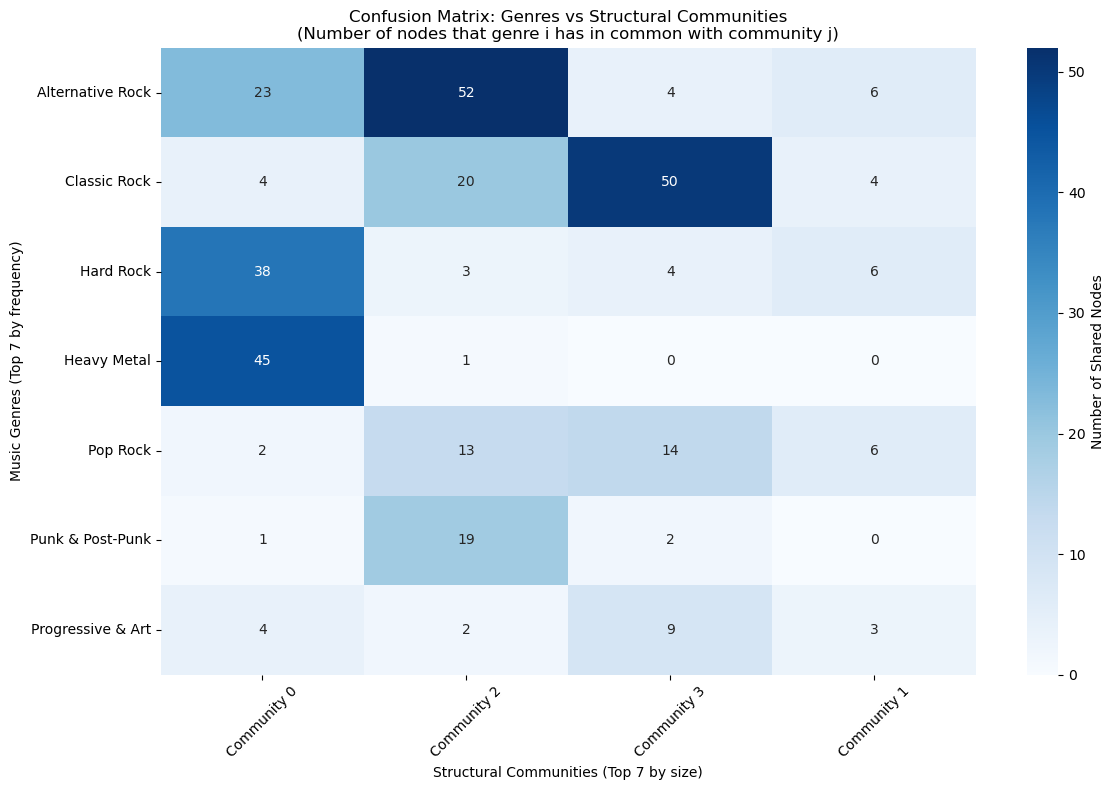


Matrix Analysis:
Total entries in matrix: 335
Maximum value in matrix: 52
Average value per cell: 11.96

Strongest association:
  Genre 'Alternative Rock' with Community 2: 52 nodes

Genre totals (across top 7 communities):
  Alternative Rock: 85 nodes
  Classic Rock: 78 nodes
  Hard Rock: 51 nodes
  Heavy Metal: 46 nodes
  Pop Rock: 35 nodes
  Punk & Post-Punk: 22 nodes
  Progressive & Art: 18 nodes

Community totals (across top 7 genres):
  Community 0: 117 nodes
  Community 2: 110 nodes
  Community 3: 83 nodes
  Community 1: 25 nodes

Normalized Confusion Matrix (by row - showing distribution of each genre across communities):
                   Comm0  Comm2  Comm3  Comm1
Alternative Rock    27.1   61.2    4.7    7.1
Classic Rock         5.1   25.6   64.1    5.1
Hard Rock           74.5    5.9    7.8   11.8
Heavy Metal         97.8    2.2    0.0    0.0
Pop Rock             5.7   37.1   40.0   17.1
Punk & Post-Punk     4.5   86.4    9.1    0.0
Progressive & Art   22.2   11.1   50.0 

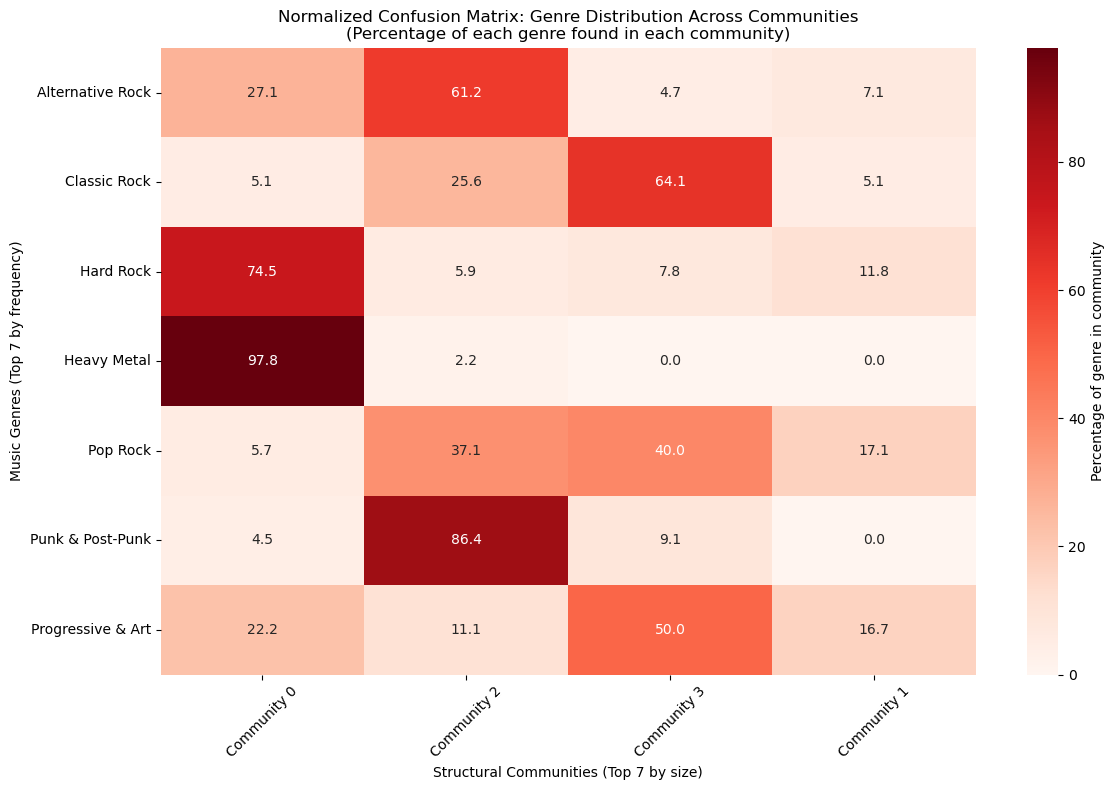

In [ ]:
def create_confusion_matrix(G_main, louvain_communities):
    """
    Create a confusion matrix comparing genres with structural communities.
    Uses the 'genre' node attribute from the graph.
    
    Args:
        G_main: NetworkX graph with nodes that have 'genre' attribute
        louvain_communities: List of community sets from Louvain algorithm
        
    Returns:
        tuple: (confusion_matrix, top_genres, top_communities, genre_to_idx, comm_to_idx)
    """
    
    # Create mapping from node to community ID
    node_to_community = {}
    for i, community in enumerate(louvain_communities):
        for node in community:
            node_to_community[node] = i
    
    # Get community sizes and find top 7 largest communities
    community_sizes = [(i, len(community)) for i, community in enumerate(louvain_communities)]
    community_sizes.sort(key=lambda x: x[1], reverse=True)
    top_7_communities = [comm_id for comm_id, size in community_sizes[:7]]
    
    # Count all genre occurrences using the 'genre' node attribute
    all_genre_counts = {}
    for node in G_main.nodes():
        if 'genre_group' in G_main.nodes[node]:
            genre = G_main.nodes[node]['genre_group']
            all_genre_counts[genre] = all_genre_counts.get(genre, 0) + 1
    
    # Get top 7 most common genres
    top_genres_with_counts = sorted(all_genre_counts.items(), key=lambda x: x[1], reverse=True)[:7]
    top_7_genres = [genre for genre, count in top_genres_with_counts]
    
    print("Top 7 genres:")
    for i, (genre, count) in enumerate(top_genres_with_counts):
        print(f"  {i+1}. {genre}: {count} nodes")
    
    print(f"\nTop 7 communities:")
    for i, (comm_id, size) in enumerate(community_sizes[:7]):
        print(f"  {i+1}. Community {comm_id}: {size} nodes")
    
    # Create confusion matrix D (7 genres × 7 communities)
    D = np.zeros((7, 4), dtype=int)
    
    # Create mappings for matrix indices
    genre_to_idx = {genre: i for i, genre in enumerate(top_7_genres)}
    comm_to_idx = {comm_id: i for i, comm_id in enumerate(top_7_communities)}
    
    # Fill the confusion matrix
    for node in G_main.nodes():
        # Check if node is in one of the top 7 communities
        if node in node_to_community and node_to_community[node] in top_7_communities:
            comm_idx = comm_to_idx[node_to_community[node]]
            
            # Check if node has one of the top 7 genres
            if 'genre_group' in G_main.nodes[node]:
                genre = G_main.nodes[node]['genre_group']
                if genre in genre_to_idx:
                    genre_idx = genre_to_idx[genre]
                    D[genre_idx, comm_idx] += 1
    
    return D, top_7_genres, top_7_communities, genre_to_idx, comm_to_idx

# Create the confusion matrix
D, top_genres, top_communities, genre_to_idx, comm_to_idx = create_confusion_matrix(
    G_main, louvain_communities
)

print(f"\nConfusion Matrix D ({len(top_genres)} genres × {len(top_communities)} communities):")
print("Rows = Genres, Columns = Communities")
print(f"Matrix shape: {D.shape}")

# Create a pandas DataFrame for better visualization
df_confusion = pd.DataFrame(
    D, 
    index=[f"G{i}: {genre}" for i, genre in enumerate(top_genres)],
    columns=[f"C{i}: Comm{comm_id}" for i, comm_id in enumerate(top_communities)]
)

print(f"\nConfusion Matrix:")
print(df_confusion)

# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(D, 
            xticklabels=[f"Community {comm_id}" for comm_id in top_communities],
            yticklabels=top_genres,
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar_kws={'label': 'Number of Shared Nodes'})

plt.title('Confusion Matrix: Genres vs Structural Communities\n(Number of nodes that genre i has in common with community j)')
plt.xlabel('Structural Communities (Top 7 by size)')
plt.ylabel('Music Genres (Top 7 by frequency)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate some statistics to interpret the confusion matrix
print(f"\nMatrix Analysis:")
print(f"Total entries in matrix: {np.sum(D)}")
print(f"Maximum value in matrix: {np.max(D)}")
print(f"Average value per cell: {np.mean(D):.2f}")

# Find the strongest genre-community associations
max_indices = np.unravel_index(np.argmax(D), D.shape)
print(f"\nStrongest association:")
print(f"  Genre '{top_genres[max_indices[0]]}' with Community {top_communities[max_indices[1]]}: {D[max_indices[0], max_indices[1]]} nodes")

# Calculate row and column sums
row_sums = np.sum(D, axis=1)  # Total nodes per genre (across all top communities)
col_sums = np.sum(D, axis=0)  # Total nodes per community (across all top genres)

print(f"\nGenre totals (across top 7 communities):")
for i, genre in enumerate(top_genres):
    print(f"  {genre}: {row_sums[i]} nodes")

print(f"\nCommunity totals (across top 7 genres):")
for i, comm_id in enumerate(top_communities):
    print(f"  Community {comm_id}: {col_sums[i]} nodes")

# Calculate normalized confusion matrix (percentages)
print(f"\nNormalized Confusion Matrix (by row - showing distribution of each genre across communities):")
# Avoid division by zero
row_sums_safe = np.where(row_sums == 0, 1, row_sums)
D_normalized_by_row = D / row_sums_safe[:, np.newaxis] * 100

df_normalized = pd.DataFrame(
    D_normalized_by_row, 
    index=[f"{genre}" for genre in top_genres],
    columns=[f"Comm{comm_id}" for comm_id in top_communities]
)
print(df_normalized.round(1))

# Visualize normalized matrix
plt.figure(figsize=(12, 8))
sns.heatmap(D_normalized_by_row, 
            xticklabels=[f"Community {comm_id}" for comm_id in top_communities],
            yticklabels=top_genres,
            annot=True, 
            fmt='.1f', 
            cmap='Reds',
            cbar_kws={'label': 'Percentage of genre in community'})

plt.title('Normalized Confusion Matrix: Genre Distribution Across Communities\n(Percentage of each genre found in each community)')
plt.xlabel('Structural Communities')
plt.ylabel('Music Genres (Top 7 by frequency)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Part 3: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.



# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

### Sentiment of band/artist pages

In [16]:
import pandas as pd

df = pd.read_csv('labmt.txt', sep='\t')

In [17]:
def calculate_sentiment(tokens: list, word_scores: pd.DataFrame) -> float:
    """
    Calculate the average sentiment score of a list of tokens based on the provided word scores DataFrame.

    Parameters:
    tokens (list): A list of words (tokens) for which to calculate the sentiment.
    word_scores (pd.DataFrame): A DataFrame containing words and their corresponding sentiment scores.

    Returns:
    float: The average sentiment score of the tokens. Returns 0 if no tokens have a score.
    """
    # Convert the DataFrame to a dictionary for faster lookups
    word_score_dict = dict(zip(word_scores['word'], word_scores['happiness_average']))

    total_score = 0
    count = 0

    for token in tokens:
        if token in word_score_dict:
            total_score += word_score_dict[token]
            count += 1

    return total_score / count if count > 0 else 0

In [24]:
import networkx as nx
import os
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Load the graph
G = rock_network

# Iterate over nodes and calculate sentiment
content_folder = "artist_pages/"
for node_id in tqdm(G.nodes):
    # Find the corresponding HTML page txt file
    file_path = os.path.join(content_folder, f"{node_id}.txt")
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        
        # Tokenize the text
        tokens = word_tokenize(text.lower())
        # print(f'Tokenized {node_id}: {len(tokens)}', end='\r')  # Print number of tokens for verification
        # Calculate sentiment
        sentiment = calculate_sentiment(tokens, df)
        # print(f'Calculated sentiment for {node_id}: {sentiment}', end='\r')  # Print sentiment for verification
        # Add sentiment as a nodal feature
        G.nodes[node_id]['sentiment'] = sentiment

# Save the updated graph
output_path = "./rock_performers_graph_sentiment.gexf"
nx.write_gexf(G, output_path)

100%|██████████| 485/485 [01:19<00:00,  6.12it/s]


In [25]:
G.nodes(data=True)

NodeDataView({'Slayer': {'word_count': 16624, 'label': 'Slayer', 'sentiment': 5.44227233304459}, 'Ted_Nugent': {'word_count': 11733, 'label': 'Ted_Nugent', 'sentiment': 5.4099722442508895}, 'Great_White': {'word_count': 7026, 'label': 'Great_White', 'sentiment': 5.528249455027949}, 'Days_of_the_New': {'word_count': 3462, 'label': 'Days_of_the_New', 'sentiment': 5.45315704088247}, 'The_Dave_Clark_Five': {'word_count': 2989, 'label': 'The_Dave_Clark_Five', 'sentiment': 5.465915700048955}, 'Keane_(band)': {'word_count': 7782, 'label': 'Keane_(band)', 'sentiment': 5.497917048388426}, 'Jimmy_Eat_World': {'word_count': 5475, 'label': 'Jimmy_Eat_World', 'sentiment': 5.554360205083442}, 'Flogging_Molly': {'word_count': 2337, 'label': 'Flogging_Molly', 'sentiment': 5.474355294629191}, 'Simple_Plan': {'word_count': 6862, 'label': 'Simple_Plan', 'sentiment': 5.539527968779048}, 'Foreigner_(band)': {'word_count': 9733, 'label': 'Foreigner_(band)', 'sentiment': 5.499498822993526}, 'Steppenwolf_(ban

Mean Sentiment: 5.485640958088458
Median Sentiment: 5.485594902948533
Variance: 0.001430311308246757
25th Percentile: 5.4619862574438525
75th Percentile: 5.508072512919954


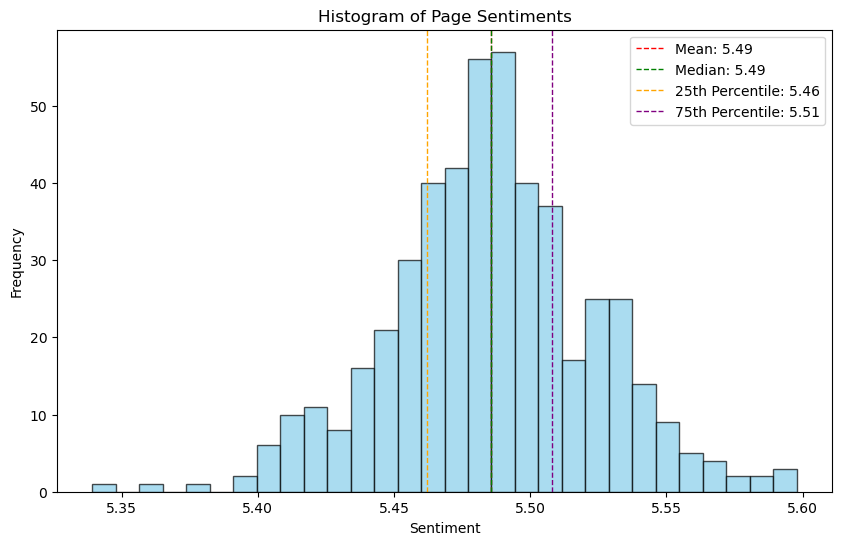

10 Saddest Artists:
Five_Finger_Death_Punch 5.339253908693132
Rage_Against_the_Machine 5.358653827589804
Rob_Zombie 5.373939242280398
Quiet_Riot 5.393716227554903
Canned_Heat 5.395937638213116
Traffic_(band) 5.399931086142283
Gary_Glitter 5.402677170589288
Drowning_Pool 5.40288112726717
Poison_(American_band) 5.404811468970925
No_Doubt 5.4058339136491105

10 Happiest Artists:
Air_Supply 5.568498791686759
Imagine_Dragons 5.569118134470019
Simple_Minds 5.570005341880715
Fun_(band) 5.573765361297617
Kenny_Loggins 5.575635852911066
Michael_Martin_Murphey 5.5852717510409
Train_(band) 5.5875156130998995
Lenny_Kravitz 5.590038381677717
The_Beach_Boys 5.591865110951487
Boys_Like_Girls 5.597888276795305


In [26]:
import numpy as np

import matplotlib.pyplot as plt

# Extract sentiment values from the graph
sentiments = [data['sentiment'] for _, data in G.nodes(data=True) if 'sentiment' in data]

# Calculate statistics
mean_sentiment = np.mean(sentiments)
median_sentiment = np.median(sentiments)
variance_sentiment = np.var(sentiments)
percentile_25 = np.percentile(sentiments, 25)
percentile_75 = np.percentile(sentiments, 75)

# Print statistics
print(f"Mean Sentiment: {mean_sentiment}")
print(f"Median Sentiment: {median_sentiment}")
print(f"Variance: {variance_sentiment}")
print(f"25th Percentile: {percentile_25}")
print(f"75th Percentile: {percentile_75}")

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(sentiments, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sentiment:.2f}')
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_sentiment:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentile_75:.2f}')
plt.title('Histogram of Page Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Find the 10 happiest and saddest artists
sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1].get('sentiment', 0))
saddest_artists = sorted_nodes[:10]
happiest_artists = sorted_nodes[-10:]

print("10 Saddest Artists:")
for artist in saddest_artists:
    print(artist[0], artist[1].get('sentiment', 0))

print("\n10 Happiest Artists:")
for artist in happiest_artists:
    print(artist[0], artist[1].get('sentiment', 0))

### Sentiment of communities

In [27]:
import json
from collections import Counter

# Load the communities
with open('louvain_comms.json', 'r') as file:
    communities = json.load(file)

# Calculate community-level sentiment
community_sentiments = []
for community in communities:
    community_sentiment = [G.nodes[band_id]['sentiment'] for band_id in community if 'sentiment' in G.nodes[band_id]]
    avg_sentiment = np.mean(community_sentiment) if community_sentiment else 0
    community_sentiments.append((community, avg_sentiment))

# Sort communities by average sentiment
community_sentiments.sort(key=lambda x: x[1])

# Save the new json along with average sentiments
community_sentiments_serializable = [{
    'community': community,
    'average_sentiment': avg_sentiment
} for community, avg_sentiment in community_sentiments]

with open('louvain_comms_sentiments.json', 'w') as file:
    json.dump(community_sentiments_serializable, file)

In [29]:
# Name each community by its three most connected bands
community_names = []
for community, _ in community_sentiments:
    band_degrees = [(band_id, G.degree(band_id)) for band_id in community]
    top_bands = sorted(band_degrees, key=lambda x: x[1], reverse=True)[:3]
    top_band_names = [band[0] for band in top_bands]
    community_names.append(top_band_names)

# Find the happiest and saddest communities
happiest_communities = community_sentiments[-3:]
saddest_communities = community_sentiments[:3]

# Print results
print("Happiest Communities:")
for i, (community, sentiment) in enumerate(happiest_communities, 1):
    print(f"{i}. Bands: {community_names[communities.index(community)]}, Sentiment: {sentiment:.2f}")

print("\nSaddest Communities:")
for i, (community, sentiment) in enumerate(saddest_communities, 1):
    print(f"{i}. Bands: {community_names[communities.index(community)]}, Sentiment: {sentiment:.2f}")

# Compare to overall sentiment
print("\nComparison to Overall Sentiment:")
print(f"Overall Mean Sentiment: {mean_sentiment:.2f}")
print(f"Variance: {variance_sentiment:.2f}")
for i, (community, sentiment) in enumerate(community_sentiments, 1):
    print(f"Community {i} Sentiment: {sentiment:.2f}, Difference from Mean: {sentiment - mean_sentiment:.2f}")

Happiest Communities:
1. Bands: ['Tommy_James_and_the_Shondells'], Sentiment: 5.50
2. Bands: ['Nickelback', 'Daughtry_(band)', 'Stone_Temple_Pilots'], Sentiment: 5.50
3. Bands: ['U2', 'Aerosmith', 'Coldplay'], Sentiment: 5.51

Saddest Communities:
1. Bands: ['Black_Sabbath', 'Metallica', 'Korn'], Sentiment: 5.44
2. Bands: ['The_Beatles', 'Led_Zeppelin', 'The_Rolling_Stones'], Sentiment: 5.47
3. Bands: ['Red_Hot_Chili_Peppers', 'Green_Day', 'Foo_Fighters'], Sentiment: 5.48

Comparison to Overall Sentiment:
Overall Mean Sentiment: 5.49
Variance: 0.00
Community 1 Sentiment: 5.44, Difference from Mean: -0.05
Community 2 Sentiment: 5.47, Difference from Mean: -0.02
Community 3 Sentiment: 5.48, Difference from Mean: -0.01
Community 4 Sentiment: 5.49, Difference from Mean: -0.00
Community 5 Sentiment: 5.50, Difference from Mean: 0.01
Community 6 Sentiment: 5.50, Difference from Mean: 0.01
Community 7 Sentiment: 5.50, Difference from Mean: 0.01
Community 8 Sentiment: 5.51, Difference from Mean

### Recreating TF-IDF results from Week 7

In [37]:
import os
import glob
import re
from collections import Counter, OrderedDict
from statistics import mean
from bs4 import BeautifulSoup
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

# Parse artist HTML files and extract genres from the infobox according to the specified structure.
import matplotlib.pyplot as plt

def clean_and_tokenize_html(html_text):
    """Remove reflist, punctuation, and stopwords; return list of clean tokens."""
    soup = BeautifulSoup(html_text, "html.parser")

    # remove references section <div class="reflist">
    for div in soup.find_all("div", class_="reflist"):
        div.decompose()

    # get visible text
    text = soup.get_text(separator=" ").lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    tokens = re.findall(r"\b[a-z]+\b", text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

def normalize_genre(g):
    g = g.strip().lower()
    # remove parenthetical comments
    g = re.sub(r"\s*\(.*?\)\s*", "", g)
    # unify various "rock'n'roll" variants to "rock and roll"
    g = re.sub(r"rock\s*['`’]?\s*n\s*['`’]?\s*roll", "rock and roll", g)
    g = re.sub(r"rock\s*&\s*roll", "rock and roll", g)
    g = re.sub(r"rock\s+and\s+roll", "rock and roll", g)
    # replace ampersand with "and"
    g = re.sub(r"&", "and", g)
    # collapse whitespace and strip punctuation at ends
    g = re.sub(r"\s+", " ", g).strip(" ,;:.")
    return g

def get_artist_name(soup, filepath):
    # try common Wikipedia heading
    h = soup.find(id="firstHeading")
    if h and h.get_text(strip=True):
        return h.get_text(strip=True)
    # fallback to title tag
    t = soup.find("title")
    if t and t.get_text(strip=True):
        title = t.get_text(strip=True)
        # often "Artist - Wikipedia"
        return re.sub(r"\s*-\s*Wikipedia.*$", "", title).strip()
    # fallback to filename
    return os.path.splitext(os.path.basename(filepath))[0]

genres_by_artist = OrderedDict()

files = glob.glob("artist_pages/**/*.txt", recursive=True)
for fp in sorted(files):
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        # try latin-1 if utf-8 fails
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    soup = BeautifulSoup(html, "html.parser")

    # find the infobox table with the exact class (may have multiple classes)
    table = None
    for tbl in soup.find_all("table", class_=True):
        classes = tbl.get("class", [])
        if "infobox" in classes and "vcard" in classes and "plainlist" in classes:
            table = tbl
            break

    artist = get_artist_name(soup, fp)
    found_genres = []

    if table:
        # find tr where th has class 'infobox-label' and text = 'Genres' (or 'Genre')
        for tr in table.find_all("tr"):
            th = tr.find("th", class_="infobox-label")
            if not th:
                continue
            label = th.get_text(strip=True).lower()
            if label in ("genres", "genre"):
                td = tr.find("td", class_="infobox-data")
                if not td:
                    continue
                # per instruction: genres located in li elements under ul under div.hlist under td.infobox-data
                div = td.find("div", class_="hlist")
                if div:
                    ul = div.find("ul")
                    if ul:
                        for li in ul.find_all("li"):
                            text = li.get_text(" ", strip=True)
                            if text:
                                # sometimes li contains comma-separated items; split conservatively
                                parts = [p.strip() for p in re.split(r"/|,|;| and | \| ", text) if p.strip()]
                                for p in parts:
                                    ng = normalize_genre(p)
                                    if ng:
                                        found_genres.append(ng)
                # if above structure not present, fallback to extracting any links or text in td
                if not found_genres:
                    # gather anchor texts under td
                    anchors = td.find_all("a")
                    if anchors:
                        for a in anchors:
                            text = a.get_text(strip=True)
                            if text:
                                ng = normalize_genre(text)
                                if ng:
                                    found_genres.append(ng)
                    else:
                        # fallback to raw td text splitting on commas
                        raw = td.get_text(" ", strip=True)
                        for p in [x.strip() for x in re.split(r",|/|;|\|| and ", raw) if x.strip()]:
                            ng = normalize_genre(p)
                            if ng:
                                found_genres.append(ng)
                break  # stop after finding the Genres row

    # deduplicate while preserving order
    seen = set()
    uniq = []
    for g in found_genres:
        if g not in seen:
            seen.add(g)
            uniq.append(g)
    if uniq:
        genres_by_artist[artist] = uniq

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tzikos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
artist_to_node = {}
nodes_by_lower = {str(n).lower(): n for n in G.nodes()}
for artist in genres_by_artist.keys():
    a_low = artist.lower()
    if artist in G:
        artist_to_node[artist] = artist  # exact match
    elif a_low in nodes_by_lower:
        artist_to_node[artist] = nodes_by_lower[a_low]
    else:
        # try relaxed matching: compare normalized whitespace/underscores
        norm = a_low.replace("_", " ").strip()
        matched = None
        for node in G.nodes():
            node_norm = str(node).lower().replace("_", " ").strip()
            if node_norm == norm:
                matched = node
                break
        if matched:
            artist_to_node[artist] = matched

matched = {a: artist_to_node[a] for a in artist_to_node}
node_to_artist = {v: k for k, v in matched.items()}


top terms per comm: 100%|██████████| 8/8 [00:00<00:00, 277.47it/s]


=== Community 1 (size=516315 tokens, unique=28649) ===
kantner	13.7907
dury	13.4692
ulvaeus	12.7207
balin	12.6891
gouldman	12.6571
gilmour	11.7265
hollies	11.7265
lumineers	11.7215
lyngstad	11.6733
hite	11.6241
kaukonen	11.5739
burchill	11.3616
gibbins	11.3055
sylvain	11.1890
polley	11.1286

=== Community 2 (size=324384 tokens, unique=20831) ===
anselmo	13.4461
scholz	12.7519
howerdel	12.1165
ellefson	11.9920
emeritus	11.9490
coheed	11.7215
hanneman	11.4165
cherone	11.3616
firehouse	11.3055
delp	11.1890
tuck	11.0666
lindemann	11.0030
inez	10.9376
heafy	10.9376
ibanez	10.9376

=== Community 3 (size=250865 tokens, unique=17816) ===
murphey	13.9271
rea	13.7091
croce	13.1766
ondrasik	12.5245
shorrock	12.3840
tork	12.0757
goble	11.5739
mcvie	11.5290
outfield	11.3055
birtles	11.2480
negron	11.0030
deyoung	10.8704
kirwan	10.8704
nesmith	10.8497
kale	10.6566

=== Community 4 (size=235842 tokens, unique=17086) ===
wentz	12.7519
delonge	12.1960
nowell	11.9490
urie	11.8151
mcilrath	11.3055
gaugh	

generate wordclouds: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


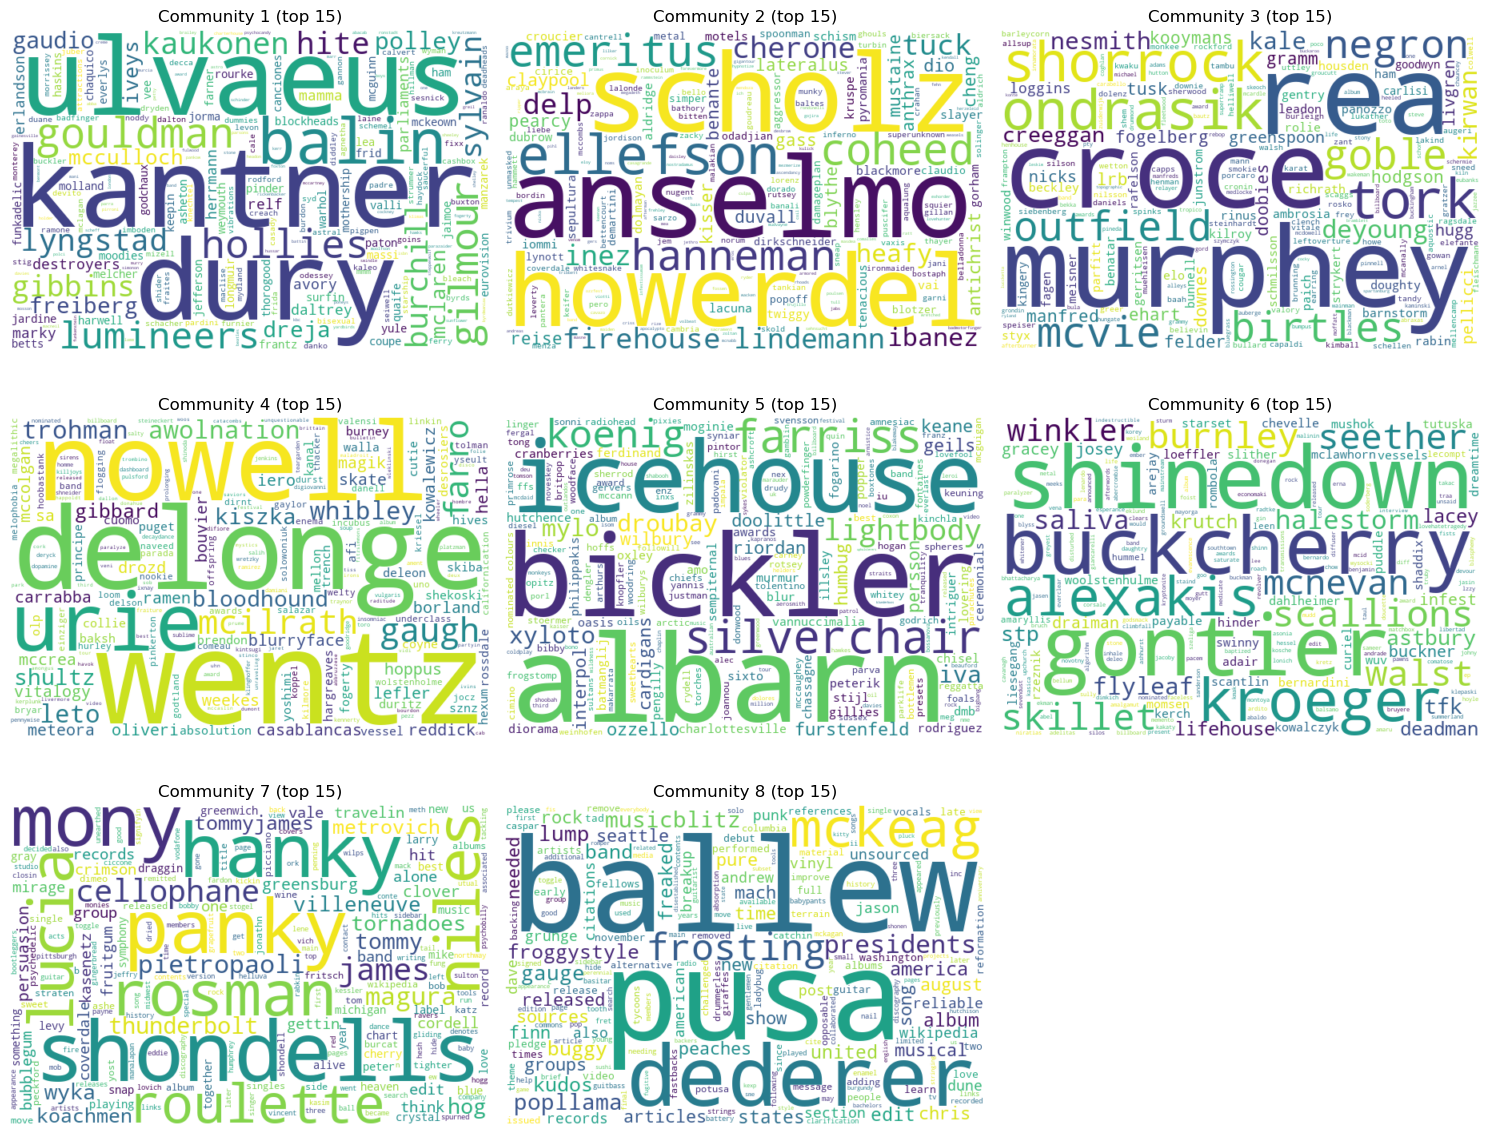

In [46]:
from collections import Counter, defaultdict
import glob, os, re
from bs4 import BeautifulSoup
import math
from networkx.algorithms.community import louvain_communities
from wordcloud import WordCloud
from tqdm import tqdm  # progress bars

# Community word-clouds for the 15 largest structural communities
# Uses notebook variables: H, node_to_artist, clean_and_tokenize_html (from earlier cells)
import matplotlib.pyplot as plt

# ensure we have Louvain communities available, else compute
comms = communities

# take 15 largest structural communities
top_n = 15
comms_sorted = sorted(comms, key=len, reverse=True)
top_comms_15 = [list(c) for c in comms_sorted[:top_n]]

# build artist -> filepath map by scanning HTML files (robust lookup)
artist_file = {}
files = glob.glob("artist_pages/**/*.txt", recursive=True)
for fp in tqdm(files, desc="scanning files"):
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    soup = BeautifulSoup(html, "html.parser")
    title = soup.find(id="firstHeading")
    if title and title.get_text(strip=True):
        name = title.get_text(strip=True)
    elif soup.title and soup.title.string:
        name = re.sub(r"- Wikipedia.*$", "", soup.title.string).strip()
    else:
        name = os.path.splitext(os.path.basename(fp))[0]
    artist_file[name] = fp

# helper to get tokens for an artist
def tokens_for_artist(artist_name):
    fp = artist_file.get(artist_name)
    if not fp:
        return []
    try:
        with open(fp, "r", encoding="utf-8") as f:
            html = f.read()
    except Exception:
        with open(fp, "r", encoding="latin-1") as f:
            html = f.read()
    return clean_and_tokenize_html(html)

# aggregate tokens per community
comm_tokens = {}
for i, comm in enumerate(tqdm(top_comms_15, desc="communities")):
    ctr = Counter()
    for node in tqdm(comm, desc=f"nodes in comm_{i}", leave=False):
        artist = node_to_artist.get(node)
        if not artist:
            continue
        toks = tokens_for_artist(artist)
        if toks:
            ctr.update(toks)
    comm_tokens[f"Community {i+1}"] = ctr

# Build TF-IDF across the top N community documents
docs = list(comm_tokens.keys())
Ndocs = len(docs)
# Document frequency
df = Counter()
for g, ctr in tqdm(comm_tokens.items(), desc="document frequency"):
    for w in ctr:
        df[w] += 1

# IDF: smooth natural-log idf
idf = {w: 1.0 + math.log(Ndocs / (1 + df_w)) for w, df_w in df.items()}

# TF variant: sublinear (1 + ln(tf)); compute TF-IDF
tfidf_by_comm = {}
for g, ctr in tqdm(comm_tokens.items(), desc="compute tfidf"):
    tfidf = {}
    for w, raw_tf in tqdm(ctr.items(), desc=f"tf terms {g}", leave=False):
        if raw_tf <= 0:
            continue
        tf_sub = 1.0 + math.log(raw_tf)
        tfidf[w] = tf_sub * idf.get(w, 1.0)
    tfidf_by_comm[g] = tfidf

# show top 15 TF-IDF words per community
top_k = 15
top_terms_by_comm = {}
for g in tqdm(docs, desc="top terms per comm"):
    top_terms = sorted(tfidf_by_comm.get(g, {}).items(), key=lambda x: -x[1])[:top_k]
    top_terms_by_comm[g] = top_terms
    print(f"=== {g} (size={sum(comm_tokens[g].values())} tokens, unique={len(comm_tokens[g])}) ===")
    for w, s in top_terms:
        print(f"{w}\t{s:.4f}")
    print()

# WordClouds (scaled TF-IDF)
try:
    cols = 3
    rows = (len(docs) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 4))
    for i, g in enumerate(tqdm(docs, desc="generate wordclouds")):
        freqs = tfidf_by_comm.get(g, {})
        if not freqs:
            continue
        max_val = max(freqs.values()) if freqs else 1.0
        scaled = {w: (v / max_val) * 100.0 for w, v in freqs.items()}
        wc = WordCloud(width=600, height=400, background_color="white", collocations=False)
        wc = wc.generate_from_frequencies(scaled)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{g} (top {top_k})")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("WordCloud not available or error:", e)
    print("Top terms printed above.")

# expose results for later use
_comm_tokens_15 = comm_tokens
_tfidf_by_comm_15 = tfidf_by_comm
_top_terms_by_comm_15 = top_terms_by_comm

### Comparison and discussion

#### Sentiment of the Communities

The sentiment analysis reveals that the differences in sentiment across communities are minimal, with the overall mean sentiment being 5.49 and a variance close to zero. The happiest communities have slightly higher sentiment values (5.50–5.51), while the saddest communities have slightly lower values (5.44–5.48). These differences are subtle, indicating that the sentiment distribution is relatively uniform across the network.

##### Happiest Communities:
1. **Bands like Tommy James and the Shondells** and **U2, Aerosmith, Coldplay** are associated with slightly higher sentiment scores. These bands are often linked to uplifting or mainstream music, which may contribute to their higher sentiment.

2. **Nickelback, Daughtry, and Stone Temple Pilots** also show higher sentiment, possibly due to their association with accessible and emotionally resonant music.

##### Saddest Communities:
1. **Bands like Black Sabbath, Metallica, and Korn** are associated with lower sentiment scores. These bands are known for darker, heavier themes, which might explain their slightly lower sentiment.

2. **The Beatles, Led Zeppelin, and The Rolling Stones** have a slightly lower sentiment, which could be influenced by the diversity of their discographies, including melancholic or introspective tracks.

3. **Red Hot Chili Peppers, Green Day, and Foo Fighters** also show lower sentiment, potentially reflecting their mix of upbeat and emotionally charged music.

#### Insights from TF-IDF Analysis

The TF-IDF results provide additional context for understanding the sentiment differences:

1. **Community-Specific Keywords**:
    - Communities with higher sentiment scores (e.g., Community 7 and Community 8) have keywords like "shondells," "hanky," "panky," and "ballew," which are associated with lighthearted or niche topics. These terms suggest a focus on specific, less emotionally intense themes.
    - Communities with lower sentiment scores (e.g., Community 1 and Community 2) feature keywords like "kantner," "gilmour," "anselmo," and "hanneman," which are tied to artists or bands known for complex, darker, or heavier themes.

2. **Community Size and Diversity**:
    - Larger communities (e.g., Community 1 and Community 2) have more diverse tokens and themes, which might dilute sentiment scores and lead to a more neutral average.
    - Smaller communities (e.g., Community 7 and Community 8) are more focused, with keywords reflecting specific genres or bands, potentially leading to more distinct sentiment scores.

3. **Genre Influence**:
    - Communities with higher sentiment often align with genres like pop rock or mainstream rock, which are generally perceived as more uplifting.
    - Communities with lower sentiment align with genres like heavy metal or alternative rock, which often explore darker or more introspective themes.

#### Conclusion

The TF-IDF findings help contextualize the sentiment results by highlighting the thematic focus of each community. Communities with keywords tied to lighter or niche topics tend to have higher sentiment, while those with keywords linked to heavier or more complex themes show lower sentiment. This suggests that the sentiment of a community is influenced by the genres, themes, and artists that dominate its content.